# DJF_PR_teleconnection: 

## Datasets Used for SSTA Comparison
The following reference datasets are employed to evaluate the ENSO-related SST patterns in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, providing high-quality estimates of surface fluxes and anomalies designed for tropical ocean and climate studies, combining in-situ measurements with satellite-derived data.
Additional datasets include:

- **20CRv2** (1871–2012): A century-scale reanalysis leveraging surface pressure observations to reconstruct global atmospheric conditions.- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and ENSO studies.
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.
- **NCEP2** (1979–2018): The second-generation reanalysis dataset from NCEP, improving upon the earlier version for global atmospheric and oceanic variability analysis.

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_tos_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_tos_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

model_pr_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}


obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2)
}

obs_pr_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2)
}

In [3]:
model_tos_datasets = {name: dataset.load() for name, dataset in model_tos_datasets.items()}
model_pr_datasets = {name: dataset.load() for name, dataset in model_pr_datasets.items()}

obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_pr_datasets = {name: dataset.load() for name, dataset in obs_pr_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [5]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=1981, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="DJF")
    cube = anomalies(cube, period="full")
    return cube


def pr_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = extract_time(cube, start_year=1979, end_year=1981, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="mm/day")
    #cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_season(cube, season="DJF")
    cube = anomalies(cube, period="full")
    cube = extract_region(cube, **region)
    return cube   

In [6]:
model_tos_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_tos_datasets.items()}
model_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in model_pr_datasets.items()}

obs_tos_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_tos_datasets.items()}
obs_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in obs_pr_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot

## Calculate Linear regression

In [8]:
def lin_regress_matrix(cubeA, cubeB):
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

# Diagnostic Level 1

In [13]:
reg2_mod = lin_regress_matrix(model_pr_datasets_prep["ACCESS-ESM1-5"], model_tos_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_pr_datasets_prep["GPCP-SG"], obs_tos_datasets_prep["HadISST"])

process = {"ACCESS-ESM1-5":reg2_mod , "HadISST":reg2_obs} 

In [18]:
reg2_mod.data.min(), reg2_mod.data.max()

(-10.618186, 10.130201)

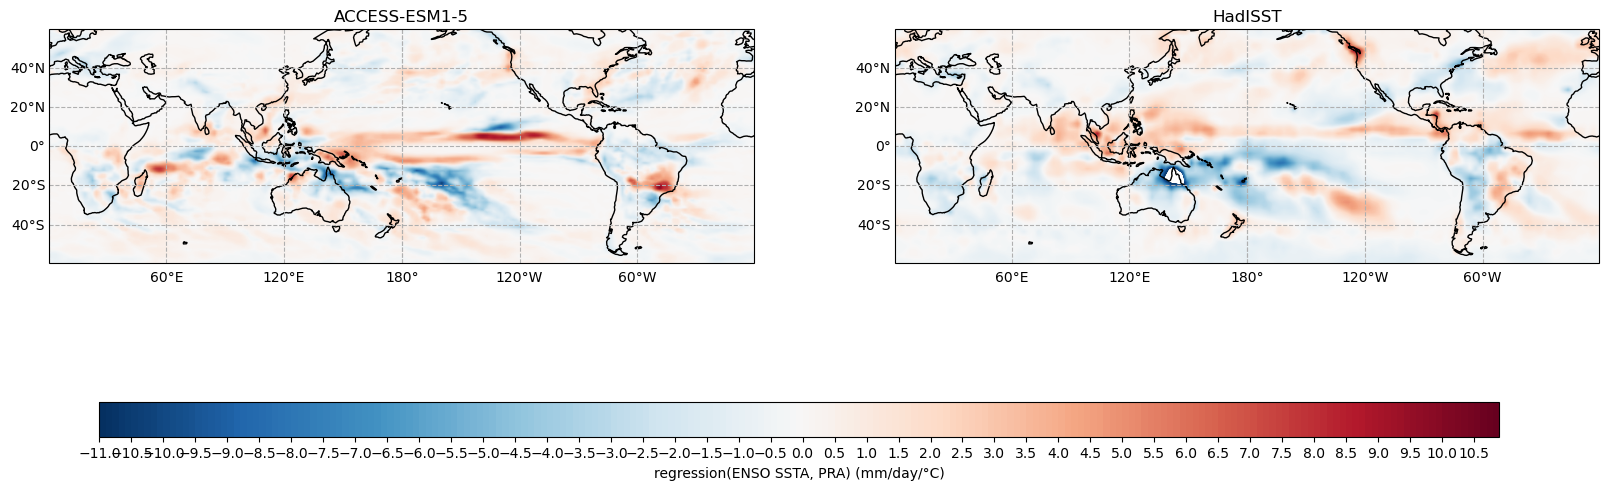

In [20]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-11,11,0.1), cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-11,11.5,0.5))
cbar.set_label('regression(ENSO SSTA, PRA) (mm/day/°C)')